# Morphism 4: Classification and Model Training: 

Function: F_{CMT} = Constructs, fits, balances, and utilizes classification models to best classify transactions as Fraud. 

Risk Function: R_{CMT} = Loss functions are utilzied to improve accuracy and decrease frequency of incorrect classifications. 

Parameters: Model Choices and Balancing Methods

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import math

In [2]:
%store -r trainDF
%store -r cleaned_trainDF_Isolation
%store -r cleaned_trainDF_Mahalanobis

# Data Preprocessing (4)

<p style="font-size:10px">Our group utilized two forms of outlier analysis Mahalanobis Outlier Detection and Isolation Forest Anomaly Detection. After utilizing both measures, datasets were saved according to what was remaining after removing outliers. These were then both applied to the original dataset to only keep transactions whose TransactionID remained in both of the newly produced datasets with outlier removed. </p>

<p style="font-size:10px">In our CART Tree model, after intitial performance analysis we applied SMOTE to balance the dataset as our elementary data analysis provided much evidence that the dataset is unbalanced. A XGBoost model was then ran after due to non-linearity of data and the fact that XGBoost framework excels with data cotaining many empty values.</p>

<p style="font-size:10px">Visualizations: CART Decision Tree Visualization (Decision Tree), Top 10 Feature Importances for CART Tree model (histogram), ROC Curve for CART Tree (line plot), Precision-Recall Curve for CART Tree (line plot), Calibration Curve for CART Tree (line plot), Top 10 Feature Importances for XGBoost model (histogram), ROC Curve for XGBoost model (line plot),  Precision-Recall Curve for XGBoost model (line plot), and Calibration Curve for XGBoost model (line plot).</p>

# -------------------------------------------------------------------------------------

# Isolation Forest Anomaly Removal Random Forest Model

In [3]:
X_cleaned_Isolation = cleaned_trainDF_Isolation.drop(columns=['isFraud'])  # Features
y_cleaned_Isolation = trainDF.loc[cleaned_trainDF_Isolation.index, 'isFraud']  # Target
X_train_isolation, X_test_isolation, y_train_isolation, y_test_isolation = train_test_split(X_cleaned_Isolation, y_cleaned_Isolation, test_size=0.3, random_state=0, stratify=y_cleaned_Isolation)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
model.fit(X_train_isolation, y_train_isolation)
y_pred_isolation = model.predict(X_test_isolation)
print("Accuracy:", accuracy_score(y_test_isolation, y_pred_isolation))
print("Classification Report:\n", classification_report(y_test_isolation, y_pred_isolation))

Accuracy: 0.9789897520163566
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    155971
           1       0.97      0.04      0.07      3475

    accuracy                           0.98    159446
   macro avg       0.97      0.52      0.53    159446
weighted avg       0.98      0.98      0.97    159446



In [4]:
conf_matrix = confusion_matrix(y_test_isolation, y_pred_isolation)
tn, fp, fn, tp = conf_matrix.ravel()
type_1_error_rate = fp / (fp + tn) 
type_2_error_rate = fn / (fn + tp)
print(f"Type 1 Error Rate (False Positive Rate): {type_1_error_rate}")
print(f"Type 2 Error Rate (False Negative Rate): {type_2_error_rate}")

Type 1 Error Rate (False Positive Rate): 2.564579312820973e-05
Type 2 Error Rate (False Negative Rate): 0.9628776978417266


**Statistics: Isolation Forest Anomaly Removal Performance Analysis**

<p style="font-size:10px">It can be seen that after removing anomalies found in Isolation Forest within dataset, that a random forest model with test_size = 0.3 has accuracy 0.98, and has a type1 error of 2*10^-5 and a type2 error of 0.963. This indicates that a basic model run on this data struggles with False negative rates, identifying many cases of fraud as non-fraudulent.</p>

# ------------------------------------------------------------------------------------

# Mahalanobis Outlier Removal Random Forest Model

In [5]:
X = cleaned_trainDF_Mahalanobis.drop(columns=['isFraud'])  # Features
y = trainDF.loc[cleaned_trainDF_Mahalanobis.index, 'isFraud']  # Target
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)  # You can adjust n_estimators as needed
model.fit(X_train_m, y_train_m) 

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=0)

In [6]:
y_pred_m = model.predict(X_test_m)
conf = confusion_matrix(y_test_m, y_pred_m)
print("Confusion Matrix:")
print(conf)

accuracy = accuracy_score(y_test_m, y_pred_m)
print(f"Accuracy: {accuracy:.4f}")

tn, fp, fn, tp = conf.ravel()
type_1_error_rate = fp / (fp + tn)  # False Positive Rate
type_2_error_rate = fn / (fn + tp)  # False Negative Rate

print(f"Type 1 Error Rate (False Positive Rate): {type_1_error_rate}")
print(f"Type 2 Error Rate (False Negative Rate): {type_2_error_rate}")

Confusion Matrix:
[[170843    120]
 [  4547   1652]]
Accuracy: 0.9737
Type 1 Error Rate (False Positive Rate): 0.0007019062604189211
Type 2 Error Rate (False Negative Rate): 0.733505404097435


**Statistics: Mahalanobis Outlier Removal Performance Analysis**

<p style="font-size:10px">It can be seen that after removing Mahalanobis outliers from the dataset, that once again accuracy is high at 0.97. The confusion matrix highlights the misclassifcation errors; with a higher false positive rate than the isolation forest, but a decently lower false-negative rate than the isolation forest. This indicates that Mahalnobis Outlier Detection and Isolation Forest Anomaly Detection have different strengths when applied to our dataset.</p>

# ------------------------------------------------------------------------------------

# Removal of Outliers (Mahalanobis + Isolation Forest)

In [7]:
filtered_trainDF = trainDF.merge(cleaned_trainDF_Mahalanobis[['TransactionID']], on='TransactionID')
filtered_trainDF = filtered_trainDF.merge(cleaned_trainDF_Isolation[['TransactionID']], on='TransactionID')

# ------------------------------------------------------------------------------------

# CART Tree Classification + SMOTE

In [8]:
# Prepare the data: Define features (X) and target (y)
X = filtered_trainDF.drop(columns=['isFraud'])  # Features (drop the target column)
y = filtered_trainDF['isFraud']  # Target

# Handle Timestamp columns (convert them to numeric if necessary)
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]' or 'Timestamp' in str(X[col].dtype):
        X[col] = X[col].astype('int64')  # Convert datetime to int (timestamps)

# Convert categorical columns to numeric using Label Encoding (for simplicity)
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object' or isinstance(X[column].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le

# Replace infinite or very large values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values for numeric columns with column mean, and categorical columns with mode
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:  # For numeric columns
        X[col] = X[col].fillna(X[col].mean())  # Assign the filled result back to the column
    else:  # For categorical columns, fill with the most frequent value
        X[col] = X[col].fillna(X[col].mode()[0])  # Assign the filled result back to the column

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CART model (DecisionTreeClassifier)
cart_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
cart_model.fit(X_train, y_train)

# Predict on the test data
y_pred_cart = cart_model.predict(X_test)

# Evaluate the model
accuracy_cart = accuracy_score(y_test, y_pred_cart)
classification_report_cart = classification_report(y_test, y_pred_cart)

# Print results
print(f"Accuracy of CART model: {accuracy_cart}")
print(f"Classification Report for CART model:\n{classification_report_cart}")


Accuracy of CART model: 0.9745338576454872
Classification Report for CART model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    103955
           1       0.43      0.47      0.45      2343

    accuracy                           0.97    106298
   macro avg       0.71      0.73      0.72    106298
weighted avg       0.98      0.97      0.98    106298



**Statistics: Initial CART Tree Model Performance Analysis (PRE SMOTE)**

<p style="font-size:10px">It can be seen that using a CART Tree Model for classification is the correct move for best identifying fraudulent transactions. The CART Tree decision model excels in scenarios like this inwhich there are many interfeature relations within the dataset that play into whether a transaction is considered fraudulent or not. There are not many linear relationships in this data which is another advanatage for using the CART Tree model. There are many anomalies in the dataset even after removing outliers, and CART Tree creates exclusive paths for them. </p>

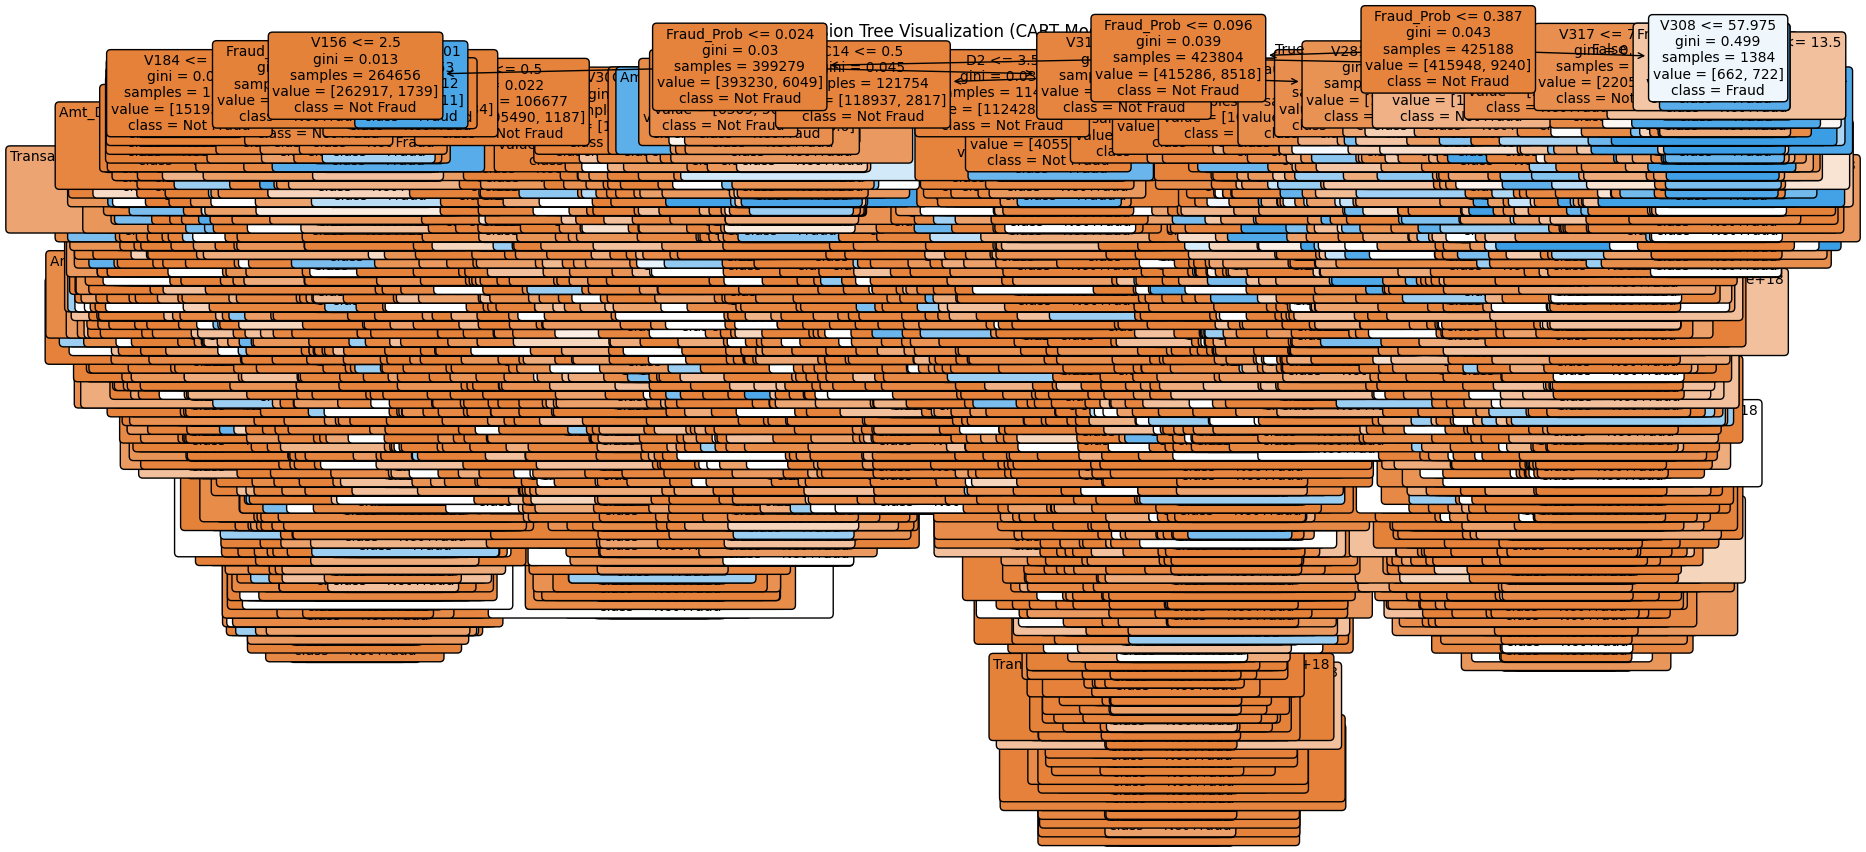

In [9]:
plt.figure(figsize=(20, 10))  # Adjust the size of the plot
plot_tree(cart_model, 
          filled=True, 
          rounded=True, 
          feature_names=X.columns,  # Use feature names for clarity
          class_names=['Not Fraud', 'Fraud'],  # Use class names
          fontsize=10)

plt.title("Decision Tree Visualization (CART Model)")
plt.show()

**Visualization: CART Tree Model Decision Tree (PRE SMOTE)**

<p style="font-size:10px">This is a visuzalization of the CART Tree Model Decision Tree, and the colors refer to how the model decided to classify each transaction. Due to the complexity of this visualization, it can be noted that this dataset has a high amount of variability. Balancing (SMOTE) could lead to more clear results. It can be seen that near the top the most prevalent features are: V156, V11, V308, and Transaction_Amt, indicating high significance with regards to flagging fraud. </p>

In [10]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
cart_model.fit(X_train_res, y_train_res)
y_pred_cart = cart_model.predict(X_test)
accuracy_cart = accuracy_score(y_test, y_pred_cart)
classification_report_cart = classification_report(y_test, y_pred_cart)
print(f"Accuracy of CART model: {accuracy_cart}")
print(f"Classification Report for CART model:\n{classification_report_cart}")

Accuracy of CART model: 0.9686917910026529
Classification Report for CART model:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    103955
           1       0.33      0.42      0.37      2343

    accuracy                           0.97    106298
   macro avg       0.66      0.70      0.68    106298
weighted avg       0.97      0.97      0.97    106298



**Statistics: CART Tree Model Decision Tree Performance Analysis(POST SMOTE)**

<p style="font-size:10px">These is the performance analysis of the CART Tree decision model after SMOTE is ran to balance the high variability within the data. Judging off the decrease in metrics for precision, recall, and f1-score across classifcation's 0 and 1, it can be seen that SMOTE introduce some noise to our data by balancing the data. For example, the f1-score went from .44 to .37 for classifier 1; this indicates that synthetic fraudulent data was added to the dataset.</p>

<p style="font-size:10px">The macro averages can also be seen to display a decrease in value: this indicates that SMOTE lead to less balanced performance across all the classes once again suggesting synthetic fraudulent data was negatively applied to the balanced dataset. </p>

<p style="font-size:10px">Accuraccy overall remains relatively the same before and after SMOTE was applied, but since this dataset is so imbalanced, accuracy is not as informative.</p>

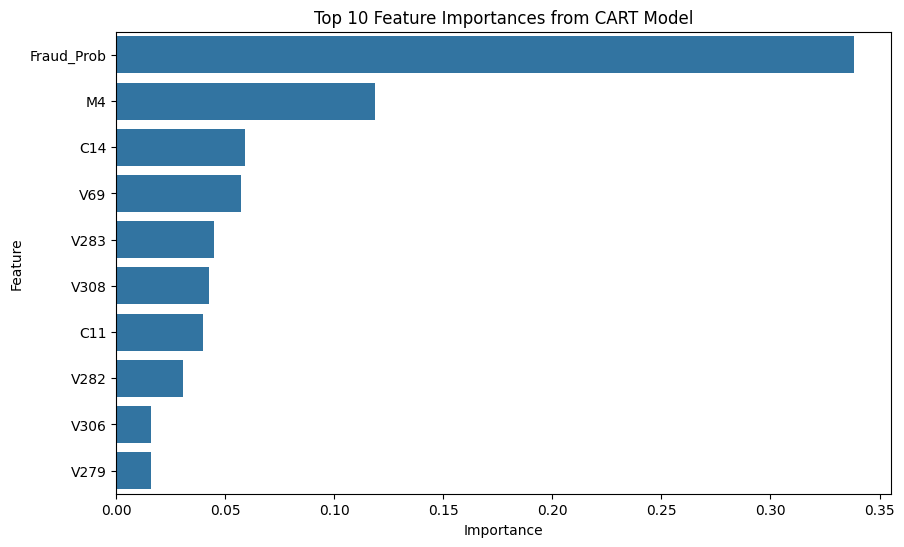

In [11]:
top_n = 10
feature_importances = pd.Series(cart_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n)

# Plot the top N features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'Top {top_n} Feature Importances from CART Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Visualization: Top 10 Feature Importances from CART Model(POST SMOTE)**

<p style="font-size:10px">It can be seen that Fraud_Prob has the highest indication towards a fraudulent transaction, but this is because it is an engineered feature taking into account the isFraud flag. It obviously should show the highest indication towards fraud.</p>

<p style="font-size:10px">Our attention instead goes to the rest of the 9 features. They are the features provided to us in the dataset that were constructed by Vesta Co. They represent encoded variables referenced in Part A. Future steps will involve accurately understanding these features and what they reference as nothing was written about them in the data description provided on Kaggle.com.</p>

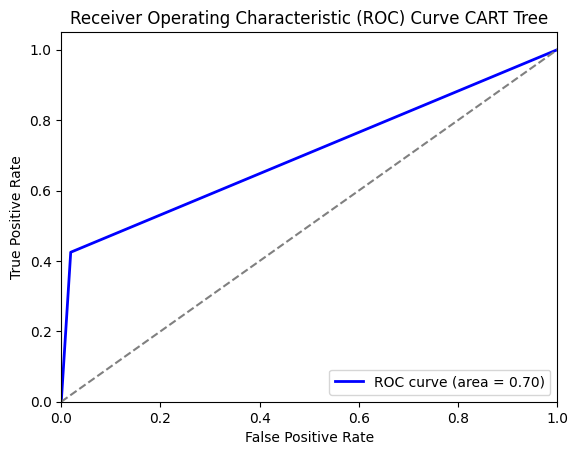

In [12]:
y_probs = cart_model.predict_proba(X_test)[:, 1]  # Probability scores for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve CART Tree')
plt.legend(loc="lower right")
plt.show()

**Visualization: ROC Curve CART Model**

This graph displays the trade off between TPR and FPR. Area under curve is 0.7, this indicates that although the model is better at randomly guessing (area under curve = 0.5), there are still improvements to be made with regard to better classification. 

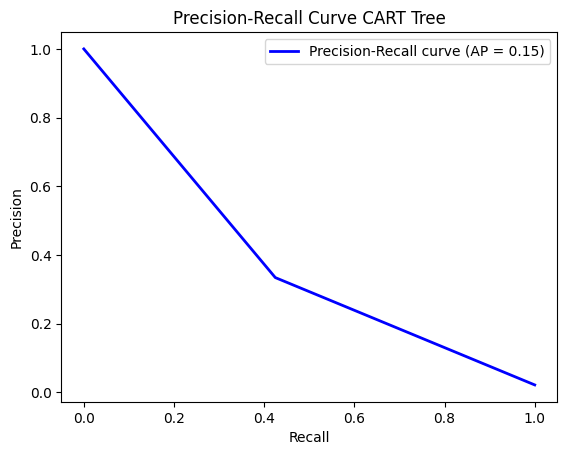

In [13]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
average_precision = average_precision_score(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve CART Tree')
plt.legend(loc="upper right")
plt.show()

**Visualization: Precision-Recall Curve CART Model**

<p style="font-size:10px">Displays tradeoff between precision and recall. Average Prevision is seen to be 0.15, and the graph can be seen to dip immensely after 0.4 recall. This indicates that the CART Tree model suffers in classification with regard to capturing even more fraudulent cases. This AP score could be improved as we improve our CART Tree model.</p>

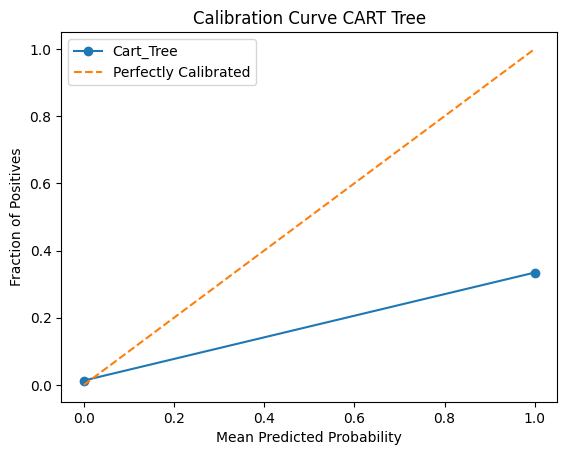

In [14]:
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

# Plot the calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Cart_Tree')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve CART Tree')
plt.legend(loc="upper left")
plt.show()

**Visualization: Calibration Curve CART Model**

<p style="font-size:10px">The Calibration Curve displays predicted probabilities from CART Tree versus truth outcomes. It can be seen that the Cart_Tree line is lower than the Perfectly Calibrated line, showing that the CART Tree model underestimates the probability of a fraudulent transaction. False negative rate is shown to be high.</p>

# ------------------------------------------------------------------------------------

# XGBoost Model

In [15]:
#xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)

y_pred = xgb_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: ",  confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy:  0.9840448550301981
Confusion Matrix:  [[103803    152]
 [  1544    799]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    103955
           1       0.84      0.34      0.49      2343

    accuracy                           0.98    106298
   macro avg       0.91      0.67      0.74    106298
weighted avg       0.98      0.98      0.98    106298



**Statistics: XGBoost Model Performance Analysis**

<p style="font-size:10px">It can be seen that just based on accuracy and the classification report that the XGBoost model performs better whether looking at all classes as a whole(macro) or individually. It can be seen that the XGBoost model performs at a slightly higher accuracy, has higher precisioun values across all classifications than CART Tree, has higher F1-scores for classification 1 and 0. These all indicate that XGBoost performs best in this unbalanced high variability environment.</p>

<p style="font-size:10px">The macro scores are higher indicating higher accuracy, precision, recall, and F1-scores across both classes.
The weighted scores are higher indicating that XGBoost performs better while taking into account class imbalances.</p>

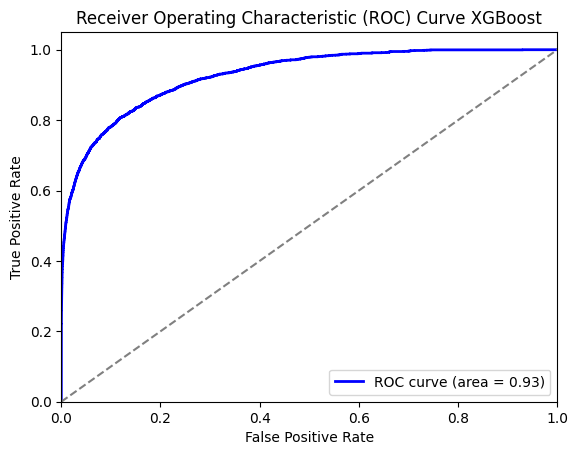

In [16]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Probability scores for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve XGBoost')
plt.legend(loc="lower right")
plt.show()

**Visualization: ROC Curve XGBoost Model**

<p style="font-size:10px">This graph displays the trade off between TPR and FPR. Area under curve is 0.93, this indcates that the XGBoost model has a much higher rate of distinguishing between non-fraud and fraudulent transactions. The curve being relatively close to upper left corner signifies the high TPR of the XGBoost model.</p>

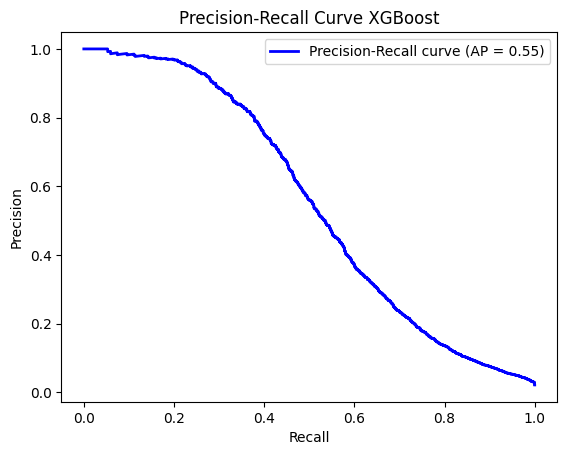

In [17]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
average_precision = average_precision_score(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve XGBoost')
plt.legend(loc="upper right")
plt.show()

**Visualization: Precision-Recall Curve XGBoost Model**
 
<p style="font-size:10px">In the XGBoost model, the average precision is seen to be 0.56, much higher than the CART Tree model. 0.56 mediocre handling of imbalanced data. It can also be seen that the model retains high precision even at low amounts of recall; this is an indication of high confidence in flagging small portionso of transactions as fraud. The model seems to perform much worse as it takes in more data.</p>

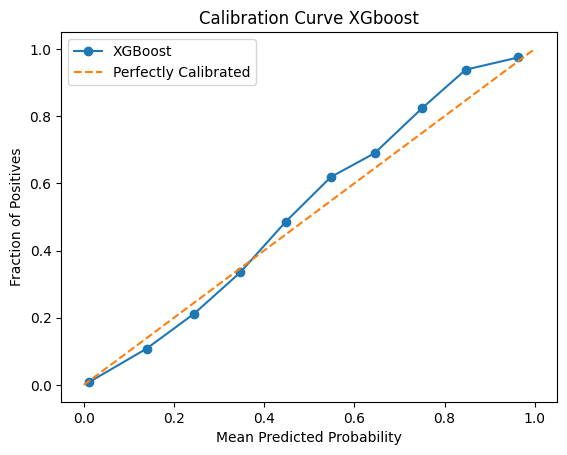

In [18]:
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

# Plot the calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve XGboost')
plt.legend(loc="upper left")
plt.show()

**Visualization: Calibration Curve XGBoost Model**

<p style="font-size:10px">It can be seen that the XGBoost model follows the perfectly calibrated line much more closely than the CART Tree Model. This indicates that the XGBoost model predictions better match the truth from the dataset. There are some deviations that go above the perfectly calibrated line, these indicate that as the mean predicted probability increases, the model begins to overestimate transactions as fraud, meaning a high FPR.</p>

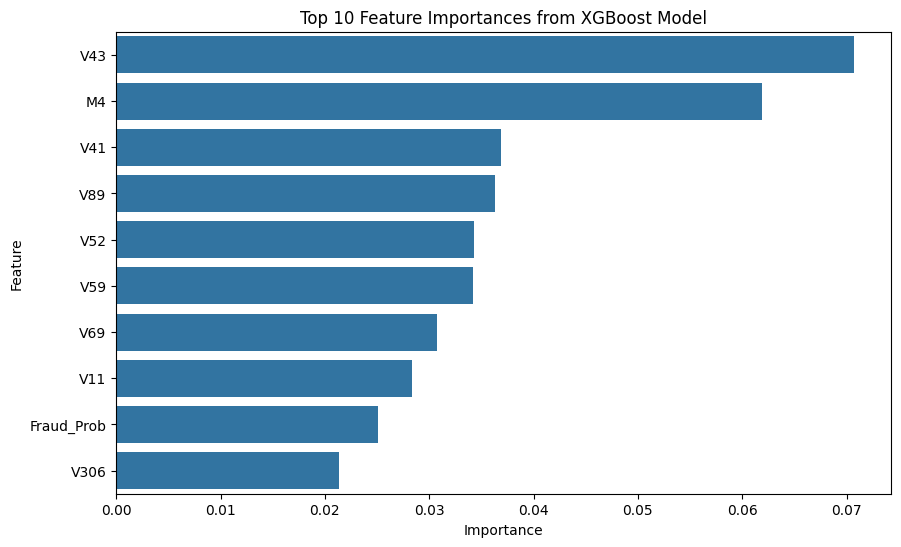

In [19]:
top_n = 10
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n)

# Plot the top N features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'Top {top_n} Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Visualization: Top 10 Feature Importances from XGBoost Model**

<p style="font-size:10px">It can be seen that the top 10 important features produced from the XGBoost model follow the same trends as the CART Tree Model. The features with highest importances once again turned out to be the encoded features provided by Vesta Co. Once again our goal is to have a better understanding of these features and to apply more analysis and significance on them within our models.</p>

In [20]:
%store xgb_model
%store filtered_trainDF

Stored 'xgb_model' (XGBClassifier)
Stored 'filtered_trainDF' (DataFrame)


# Overall Machine Learning Morphism Workflow:

X_raw -> Y_pred = F_classification ∘ F_featureEngineering ∘ F_outlierVariance ∘ F_ElementaryDataAnalysis(X_raw) 

<p style="font-size:10px">The Machine Learning Morphisms of each file are present at the top of each file. It can be seen that once X_raw is fead into ElementaryDataAnalysis that the Machine learning morphism begins and proceeds from each step to the next until a classification ruling is produced. </p> 

# Source Code

https://github.com/ferrisatassi1/IEEE_Fraud_Detection_Atassi_Hang (Pre-Changes-Branch) NOT MAIN BRANCH

# Next Steps

<p style="font-size:10px">- Your plan of how to continue or improve your methods/models and the timeline of next steps.</p>

-First Week- 
<p style="font-size:10px">- Our first priority upon submitting this project is to tune hyperparameters within our CART Tree and XGBoost models</p>
- <p style="font-size:10px">Work with top 10 feature importances to further tune our models.</p>
<p style="font-size:10px">- Understand Preconstructed features in dataset made by Vesta Co.</p>

-Second Week-
<p style="font-size:10px">- Better our usage of PCA to learn more from it in terms of data cleaning/feature engineering</p>
<p style="font-size:10px">- Try out different sampling techniques other than SMOTE to find one that best fits our data</p>
<p style="font-size:10px">- Lower data dimensionality </p>

-Third Week-
<p style="font-size:10px">- Add regularization to XGBoost and CART Tree</p>
<p style="font-size:10px">- Calibration to check produced probabilities from model</p>

-Fourth Week-
<p style="font-size:10px">- Test Model on different sampling sizes/Using data from unused datasets</p>

# Sources

<p style="font-size:10px">Bhattacharyya, Siddhartha, et al. “Data Mining for Credit Card Fraud: A Comparative Study.” Decision Support Systems, vol. 50, no. 3, Feb. 2011, pp. 602–613, https://doi.org/10.1016/j.dss.2010.08.008.</p>

<p style="font-size:10px">Bolton, Richard, and David Hand. Unsupervised Profiling Methods for Fraud Detection. 2001.</p>

<p style="font-size:10px">Castillo, Michelle. “Why Credit Card Fraud Alerts Are Rising, and How Worried You Should Be about Them.” CNBC, 12 Sept. 2024, www.cnbc.com/2024/09/12/why-credit-card-fraud-alerts-are-rising.html.</p>

<p style="font-size:10px">Fiore, Ugo, et al. “Using Generative Adversarial Networks for Improving Classification Effectiveness in Credit Card Fraud Detection.” Information Sciences, vol. 479, Apr. 2019, pp. 448–455, https://doi.org/10.1016/j.ins.2017.12.030.</p>

<p style="font-size:10px">Foote, Keith D. “A Brief History of Machine Learning - DATAVERSITY.” DATAVERSITY, 3 Dec. 2021, www.dataversity.net/a-brief-history-of-machine-learning/.</p>

<p style="font-size:10px">“IEEE-CIS Fraud Detection.” @Kaggle, 2024, www.kaggle.com/competitions/ieee-fraud-detection/leaderboard. Accessed 28 Oct. 2024.</p>

<p style="font-size:10px">Xiao, Zhijia. “IEEE-CIS Fraud Detection Based on XGB.” Applied Economics and Policy Studies, 1 Jan. 2024, pp. 1785–1796, https://doi.org/10.1007/978-981-97-0523-8_159. Accessed 28 Oct. 2024.</p>